In [1]:
import platform
import matplotlib.pyplot as plt
import random

# This Jupyter magic is pretty much compulsory if you want to do any plotting:
%matplotlib inline

# This line suppresses warnings caused by creating a lot of plots:
plt.rcParams.update({'figure.max_open_warning': 0})

# Download & visualise data

2018-07-13 08:28:09,988 - MultiSeries - INFO - Initialising MultiSeries: data_vs_times_df.shape = (12775, 4), data_vs_times_df.shape = None, time_colname = day_of_year, series_id_colnames = weather_station, value_colnames_vs_times = None, value_colnames_vs_series = None
2018-07-13 08:28:09,989 - MultiSeries - INFO - Inferred time-label value colnames = ['precav', 'tempav']


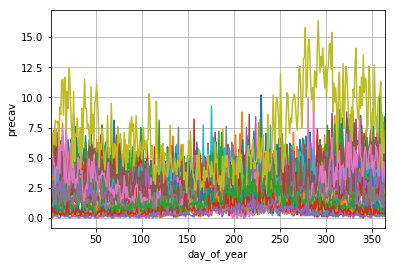

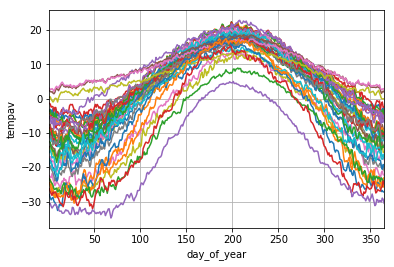

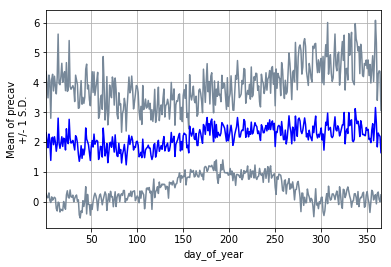

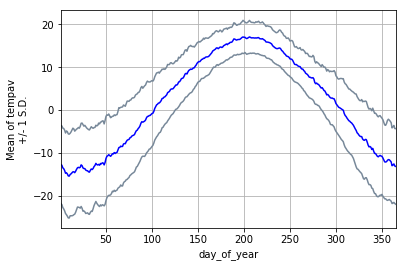

In [2]:
from pysf.data import download_ramsay_weather_data_dfs, MultiSeries

# Data: growth
(weather_vs_times_df, weather_vs_series_df) = download_ramsay_weather_data_dfs()
data_weather = MultiSeries(data_vs_times_df=weather_vs_times_df, data_vs_series_df=weather_vs_series_df, time_colname='day_of_year', series_id_colnames='weather_station')

data_weather.visualise()
data_weather.visualise_moments()

# Randomly split the series 70%/30% and visualise

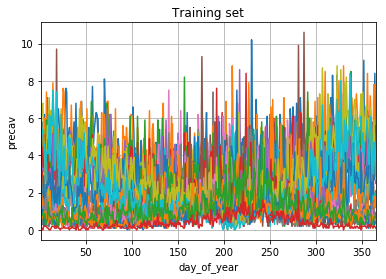

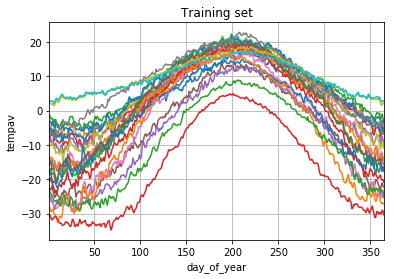

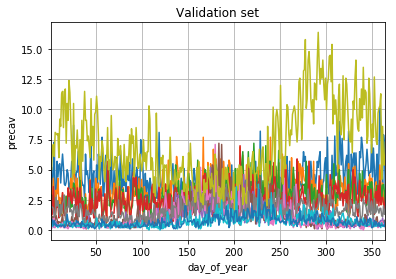

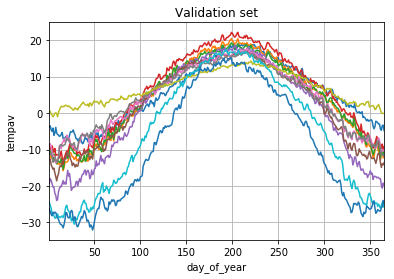

In [3]:
random.seed(777) # for reproducibility

from sklearn.model_selection import ShuffleSplit

splits = list(data_weather.generate_series_folds(series_splitter=ShuffleSplit(test_size=0.30, n_splits=1)))
(training_set, validation_set) = splits[0]

training_set.visualise(title='Training set')
validation_set.visualise(title='Validation set')

# Fit-predict-score workflow on a predictor with preset hyperparameters

Build a composite predictor and manually set its hyperparameters:

In [4]:
from pysf.predictors.framework import PipelinePredictor, MultiCurveTabularPredictor
from pysf.transformers.smoothing import SmoothingSplineTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

sklearn_estimator_pipeline = Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA()), ('ols', LinearRegression())])
multiseries_smoothing_pcr_predictor = PipelinePredictor(chain = [ SmoothingSplineTransformer() , MultiCurveTabularPredictor(classic_estimator=sklearn_estimator_pipeline)  ])
multiseries_smoothing_pcr_predictor.set_parameters({ 'pca__n_components' : 3 , 'spline_degree' : 5 , 'smoothing_factor' : 'default' })


Define the common parameters of the fit-predict-score functions:

In [5]:
import numpy as np

common_prediction_times = np.arange(301, 366)
common_input_time_feature = False
common_input_non_time_features = ['tempav', 'precav']
common_prediction_features = ['tempav', 'precav']


Fit the predictor to the training set:

In [6]:
multiseries_smoothing_pcr_predictor.fit(X=training_set, prediction_times=common_prediction_times, input_time_feature=common_input_time_feature, input_non_time_features=common_input_non_time_features, prediction_features=common_prediction_features)


/Users/Ahmed/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Predict the last 65 days of the year and assess the results.

In [7]:
Y_hat = multiseries_smoothing_pcr_predictor.predict(X=validation_set, prediction_times=common_prediction_times, input_time_feature=common_input_time_feature, input_non_time_features=common_input_non_time_features, prediction_features=common_prediction_features)


/Users/Ahmed/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Visualise our predictions:

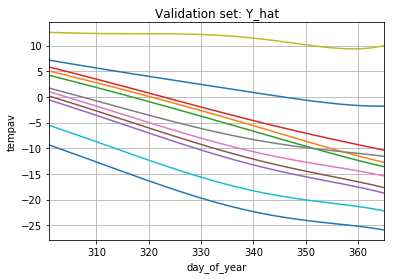

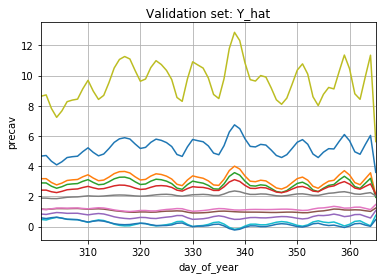

In [8]:
Y_hat.visualise(title='Validation set: Y_hat')


Visualise the ground truth (i.e. the validation set):

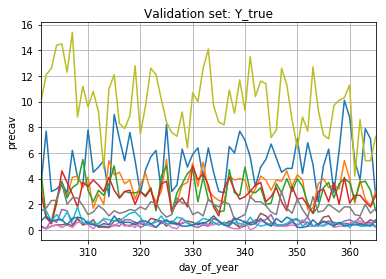

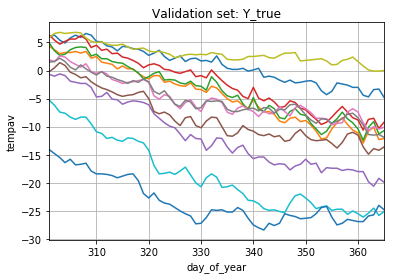

In [9]:
Y_true = validation_set.subset_by_times(common_prediction_times)
Y_true.visualise(title='Validation set: Y_true')

It's time to assess the quality of our predictions. Visualise the residuals, calculate error metrics from those residuals, and visualise the RMSE error metric:

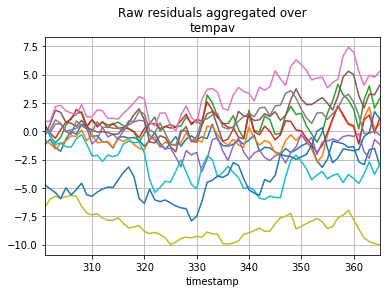

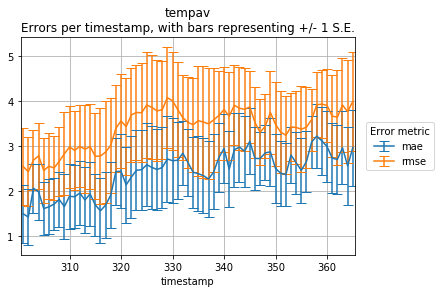

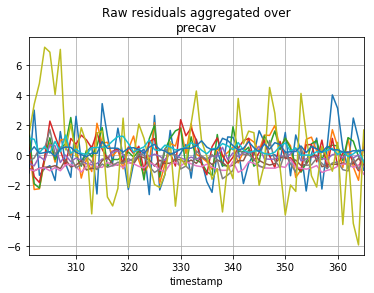

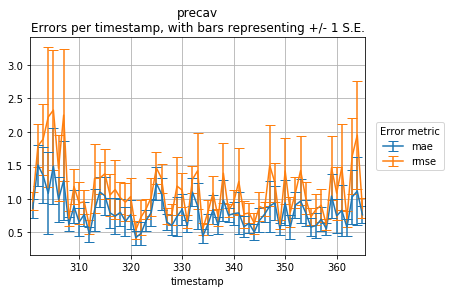

In [10]:
from pysf.errors import ErrorCurve

for prediction_feature in common_prediction_features:
    residuals = Y_true.get_raw_residuals(Y_hat=Y_hat, value_colnames_vs_times_filter=prediction_feature)
    residuals.visualise()
    err = ErrorCurve.init_from_raw_residuals(raw_residuals_obj=residuals)
    err.visualise_per_timestamp(title=prediction_feature)


# Fit-predict-score workflow for a self-tuning predictor

To tune our predictor for the optimal hyperparameter settings, we will wrap it in a self-tuning composite predictor. This takes care of the optimisation of the hyperparams and can be used seamlessly as part of a wider workflow.

Our definition means we will sample 6 parameter sets at random, the fitting step will 
perform 5-fold cross-validation (the default), and will tune for the "tempav" feature (even though we may separately choose to predict for both features simultaneously). 

In [11]:
from pysf.predictors.tuning import TuningOverallPredictor
from sklearn.model_selection import ParameterSampler

tuning_overall_multiseries_smoothing_pcr_predictor = TuningOverallPredictor(predictor_template=multiseries_smoothing_pcr_predictor, scoring_metric='rmse', scoring_feature_name='tempav'
                                                   , parameter_iterator=ParameterSampler(n_iter=5, param_distributions={  'pca__n_components' : [ 3, 5, 7, 9 ]
                                                                                                                         , 'spline_degree' : [ 3, 5 ]
                                                                                                                         , 'smoothing_factor' : [ 'default', '0', '50', '100', '150', '200' ]
                                                                                                                         }))



Perform the fit-predict-score workflow, exactly as before. The tuning predictor's fit step tunes its inner predictor and then trains it (with optimal hyperparameters set) against the full training set, ready for use in prediction:

In [12]:
random.seed(777) # for reproducibility

tuning_overall_multiseries_smoothing_pcr_predictor.fit(X=training_set, prediction_times=common_prediction_times, input_time_feature=common_input_time_feature, input_non_time_features=common_input_non_time_features, prediction_features=common_prediction_features)


2018-07-13 08:28:16,618 - TuningOverallPredictor - INFO - Outer CV Loop. Fold 1. Training = [ 6  7  8 12 13 14 15 16 17 18 19 21 24 25 26 29 30 32 34] / Validation = [0 1 3 4 5]
2018-07-13 08:28:16,619 - TuningOverallPredictor - INFO - Within fold 1, started evaluating param_dict 1/5: {'pca__n_components': 7, 'spline_degree': 3, 'smoothing_factor': '50'}
/Users/Ahmed/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/Ahmed/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
2018-07-13 08:28:18,225 - TuningOverallPredictor - INFO - Within fold 1, finished evaluating param_dict 1/5: {'pca__n_components': 7, 'spline_degree': 3, 'smoothing_factor': '50'}
2018-07-13 08:2

/Users/Ahmed/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


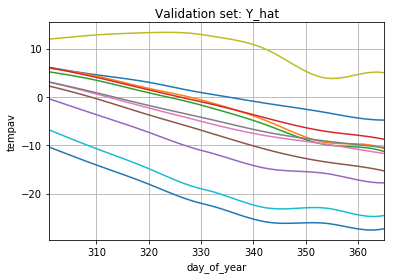

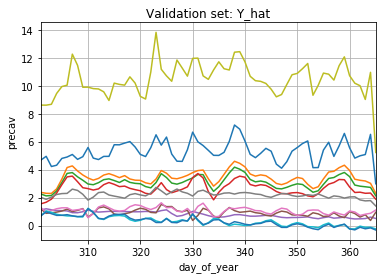

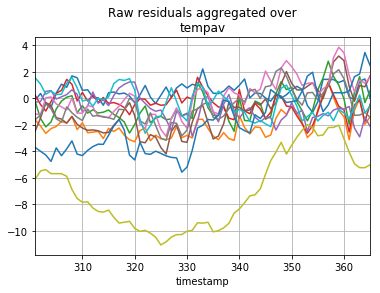

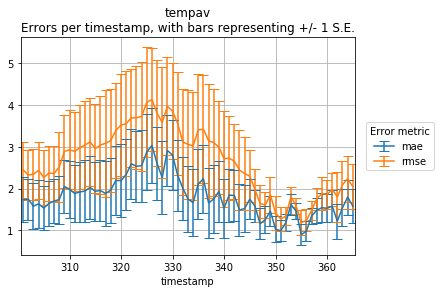

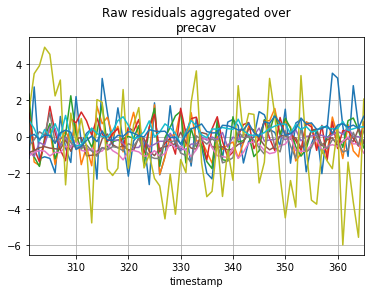

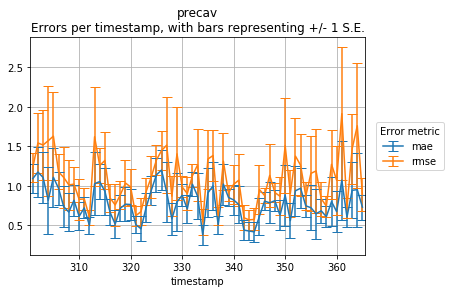

In [13]:
Y_hat = tuning_overall_multiseries_smoothing_pcr_predictor.predict(X=validation_set, prediction_times=common_prediction_times, input_time_feature=common_input_time_feature, input_non_time_features=common_input_non_time_features, prediction_features=common_prediction_features)
Y_hat.visualise(title='Validation set: Y_hat')

for prediction_feature in common_prediction_features:
    residuals = Y_true.get_raw_residuals(Y_hat=Y_hat, value_colnames_vs_times_filter=prediction_feature)
    residuals.visualise()
    err = ErrorCurve.init_from_raw_residuals(raw_residuals_obj=residuals)
    err.visualise_per_timestamp(title=prediction_feature)

# Workflow for estimating the generalisation error

Now we will assess the expected prediction error using nested cross-validation. We will also compare our predictor against a set of baselines. The evaluator will prepare identical cross validation folds and then iterate over various targets. Each target is defined by a predictor and the particular input and output fields to use.

In [14]:
from pysf.generalisation import GeneralisationPerformanceEvaluator
from pysf.predictors.baselines import SeriesMeansPredictor, ZeroPredictor, TimestampMeansPredictor, SeriesLinearInterpolator

evaluator_weather = GeneralisationPerformanceEvaluator(data=data_weather, prediction_times=common_prediction_times)

evaluator_weather.add_to_targets(   combos_of_input_time_column=[ True ], combos_of_input_value_colnames=[ None ], combos_of_output_value_colnames=[ common_prediction_features ]
                                , predictor_templates={   'Baseline single-series series means' : SeriesMeansPredictor()
                                                        , 'Baseline 0 values' : ZeroPredictor()
                                                        , 'Baseline multi-series timestamp means' : TimestampMeansPredictor()
                                                        , 'Baseline single-series series linear interpolator' : SeriesLinearInterpolator()
                                                      })
    
evaluator_weather.add_to_targets(   combos_of_input_time_column=[ False ], combos_of_input_value_colnames=[ common_prediction_features ], combos_of_output_value_colnames=[ common_prediction_features ]
                                , predictor_templates={   'Multi-series self-tuning Smoothing PCR' : tuning_overall_multiseries_smoothing_pcr_predictor })
    


This step performs (5-fold, by default) cross-validation, with a new objective -- to assess the generalisation error of the configured prediction strategies, as defined above.

Note that our self-tuning predictor itself performs its own cross-validation step. Therefore, that predictor effectively uses nested cross validation (CV within CV):

In [15]:
random.seed(777) # for reproducibility

results_df = evaluator_weather.evaluate()

2018-07-13 08:28:57,320 - GeneralisationPerformanceEvaluator - INFO - Started full evaluation. series_splitter=KFold(n_splits=5, random_state=None, shuffle=False)
2018-07-13 08:28:57,344 - GeneralisationPerformanceEvaluator - INFO - Outer CV Loop. Fold 1. Training = [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34] / Validation = [0 1 2 3 4 5 6]
2018-07-13 08:28:57,345 - GeneralisationPerformanceEvaluator - INFO - Within fold 1, started evaluating individual target 1/5: Target(Baseline 0 values. Use time as Covariate: True. Non-time Covariates: None. Responses: ['tempav', 'precav']. Predictor: ZeroPredictor(_classic_estimator = None, allow_missing_values = False)
2018-07-13 08:28:57,468 - GeneralisationPerformanceEvaluator - INFO - Within fold 1, finished evaluating individual target 1/5: Target(Baseline 0 values. Use time as Covariate: True. Non-time Covariates: None. Responses: ['tempav', 'precav']. Predictor: ZeroPredictor(_classic_estimator = Du

Now we have new charts to assess the estimated generalisation error, both overall and per-timestamp:

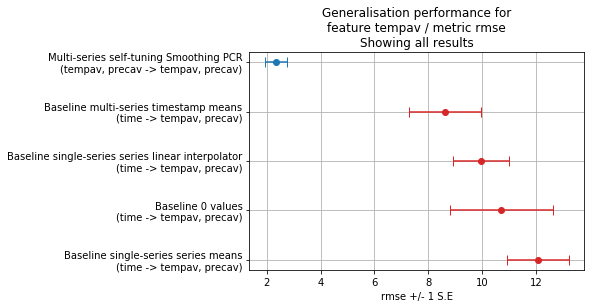

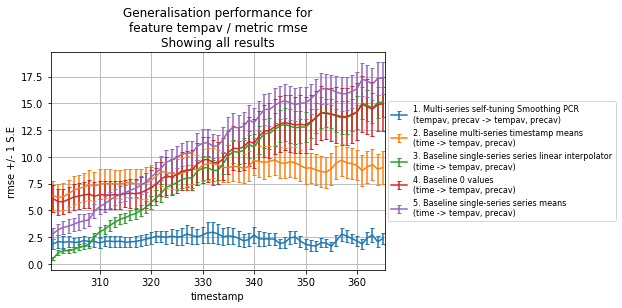

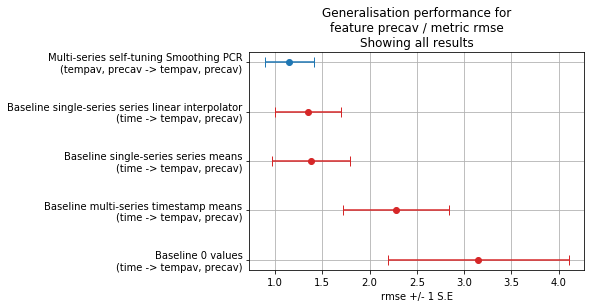

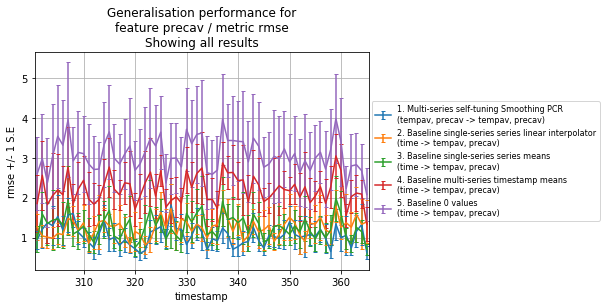

In [16]:
evaluator_weather.chart_overall_performance(feature_name='tempav', metric='rmse')
evaluator_weather.chart_per_timestamp_performance(feature_name='tempav', metric='rmse')

evaluator_weather.chart_overall_performance(feature_name='precav', metric='rmse')
evaluator_weather.chart_per_timestamp_performance(feature_name='precav', metric='rmse')


Visually, our strategy outperforms all 4 baselines when predicting the "tempav" feature; however, results are less clear when predicting the "precav" feature.